Analysis for section Comparison of Core Climate Variables over Canada

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import glob
from xscen.config import CONFIG, load_config
import cartopy.crs as ccrs
import pandas as pd
import xclim as xc
import spirograph.matplotlib as sp
import string
from dask.distributed import Client


import xscen as xs
from dask.diagnostics import ProgressBar

load_config('paths_pc.yml', verbose=(__name__ == '__main__'), reset=True)
tdd={'xarray_open_kwargs':{'decode_timedelta': False}}
pd.set_option('display.max_columns', None)
sp.utils.set_mpl_style('ouranos')

cbar= {'tg_mean': 'plasma',
       'tx_mean': 'plasma',
       'tn_mean': 'plasma',
       'prcptot': 'viridis_r'
      }

cbar_bias= {'tg_mean': 'temp_div',
       'tx_mean': 'temp_div',
       'tn_mean': 'temp_div',
       'prcptot': 'prec_div'
      }
time_name= {'AS-JAN':{'1': 'annual'},
           'QS-DEC':{'3':'MAM',
                     '6':'JJA',
                     '9':'SON',
                     '12':'DEC'}}

var2name={'prcptot':r'$\tt{pr}$', 'tx_mean':r'$\tt{tasmax}$', 'tn_mean':r'$\tt{tasmin}$'}


map_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)


INFO:xscen.config:Updated the config with paths_pc.yml.


# Load project catalog

In [2]:
project={'name': 'platform-comparison',
 'version': '1.0.0',
 'description': "Comparing canadian climate platform",
 'id': 'pc'}
pcat_espo = xs.ProjectCatalog(CONFIG['paths']['pcat_espo'])
pcat = xs.ProjectCatalog(CONFIG['paths']['project_catalog'])
pcat.df


id        type  \
0         climatedata_CMIP6_ScenarioMIP_ssp126_CAN-PCIC  simulation   
1         climatedata_CMIP6_ScenarioMIP_ssp585_CAN-PCIC  simulation   
2         climatedata_CMIP6_ScenarioMIP_ssp245_CAN-PCIC  simulation   
3         climatedata_CMIP6_ScenarioMIP_ssp126_CAN-PCIC  simulation   
4         climatedata_CMIP6_ScenarioMIP_ssp585_CAN-PCIC  simulation   
...                                                 ...         ...   
6605  climatedata_CMIP6_ScenarioMIP_EC-Earth3-Veg_ss...  simulation   
6606  climatedata_CMIP6_ScenarioMIP_CNRM-CM6-1_ssp58...  simulation   
6607      climatedata_CMIP6_ScenarioMIP_ssp585_CAN-PCIC  simulation   
6608      climatedata_CMIP6_ScenarioMIP_ssp585_CAN-PCIC  simulation   
6609      climatedata_CMIP6_ScenarioMIP_ssp585_CAN-PCIC  simulation   

          processing_level bias_adjust_institution bias_adjust_project  \
0         ensemble-30ymean                    PCIC         climatedata   
1         ensemble-30ymean                    PCIC         climatedata   
2         ensemble-30ymean                    PCIC         climatedata   
3         ensemble-30ymean                    PCIC         climatedata   
4         ensemble-30ymean                    PCIC         climatedata   
...                    ...                     ...                 ...   
6605             abs-delta                    PCIC         climatedata   
6606             abs-delta                    PCIC         climatedata   
6607   ensemble-indicators                    PCIC         climatedata   
6608  ensemble-climatology                    PCIC         climatedata   
6609    ensemble-abs-delta                    PCIC         climatedata   

     mip_era     activity driving_institution driving_model institution  \
0      CMIP6  ScenarioMIP                 NaN           NaN         NaN   
1      CMIP6  ScenarioMIP                 NaN           NaN         NaN   
2      CMIP6  ScenarioMIP                 NaN           NaN         NaN   
3      CMIP6  ScenarioMIP                 NaN           NaN         NaN   
4      CMIP6  ScenarioMIP                 NaN           NaN         NaN   
...      ...          ...                 ...           ...         ...   
6605   CMIP6  ScenarioMIP                 NaN           NaN         NaN   
6606   CMIP6  ScenarioMIP                 NaN           NaN         NaN   
6607   CMIP6  ScenarioMIP                 NaN           NaN         NaN   
6608   CMIP6  ScenarioMIP                 NaN           NaN         NaN   
6609   CMIP6  ScenarioMIP                 NaN           NaN         NaN   

             source experiment member  xrfreq frequency  \
0               NaN     ssp126    NaN      MS       mon   
1               NaN     ssp585    NaN      MS       mon   
2               NaN     ssp245    NaN      MS       mon   
3               NaN     ssp126    NaN  QS-DEC       qtr   
4               NaN     ssp585    NaN  QS-DEC       qtr   
...             ...        ...    ...     ...       ...   
6605  EC-Earth3-Veg     ssp585    NaN  AS-JAN        yr   
6606     CNRM-CM6-1     ssp585    NaN  AS-JAN        yr   
6607            NaN     ssp585    NaN  AS-JAN        yr   
6608            NaN     ssp585    NaN  AS-JAN        yr   
6609            NaN     ssp585    NaN  AS-JAN        yr   

                                               variable    domain  \
0     (r20mm_delta_1971_2000_p10, r20mm_delta_1971_2...  CAN-PCIC   
1     (r20mm_delta_1971_2000_p10, r20mm_delta_1971_2...  CAN-PCIC   
2     (r20mm_delta_1971_2000_p10, r20mm_delta_1971_2...  CAN-PCIC   
3     (r20mm_delta_1971_2000_p10, r20mm_delta_1971_2...  CAN-PCIC   
4     (r20mm_delta_1971_2000_p10, r20mm_delta_1971_2...  CAN-PCIC   
...                                                 ...       ...   
6605                       (dlyfrzthw_delta_1991_2020,)  CAN-PCIC   
6606                       (dlyfrzthw_delta_1991_2020,)  CAN-PCIC   
6607      (dlyfrzthw_p10, dlyfrzthw_p50, dlyfrzthw_p90)  CAN-PCIC   
6608      (

# climatology

Moderate Emissions
prcptot 6061.832 -787.4553 164.28004 190.2276
tx_mean 3.6019802 -12.450953 -0.7019643 1.3626461
tn_mean 5.7577662 -13.931704 -0.33037814 1.7984495
prcptot 6745.683 -825.6974 175.532 209.46916
tx_mean 3.0308313 -12.789555 -1.1207731 1.3724451
tn_mean 5.332758 -14.140579 -0.7025398 1.8200674
High Emissions
prcptot 6881.3247 -915.11975 159.74106 212.82071
tx_mean 1.9138331 -14.485905 -2.6797113 1.3437121
tn_mean 4.0343227 -15.323456 -2.2147481 1.8952451


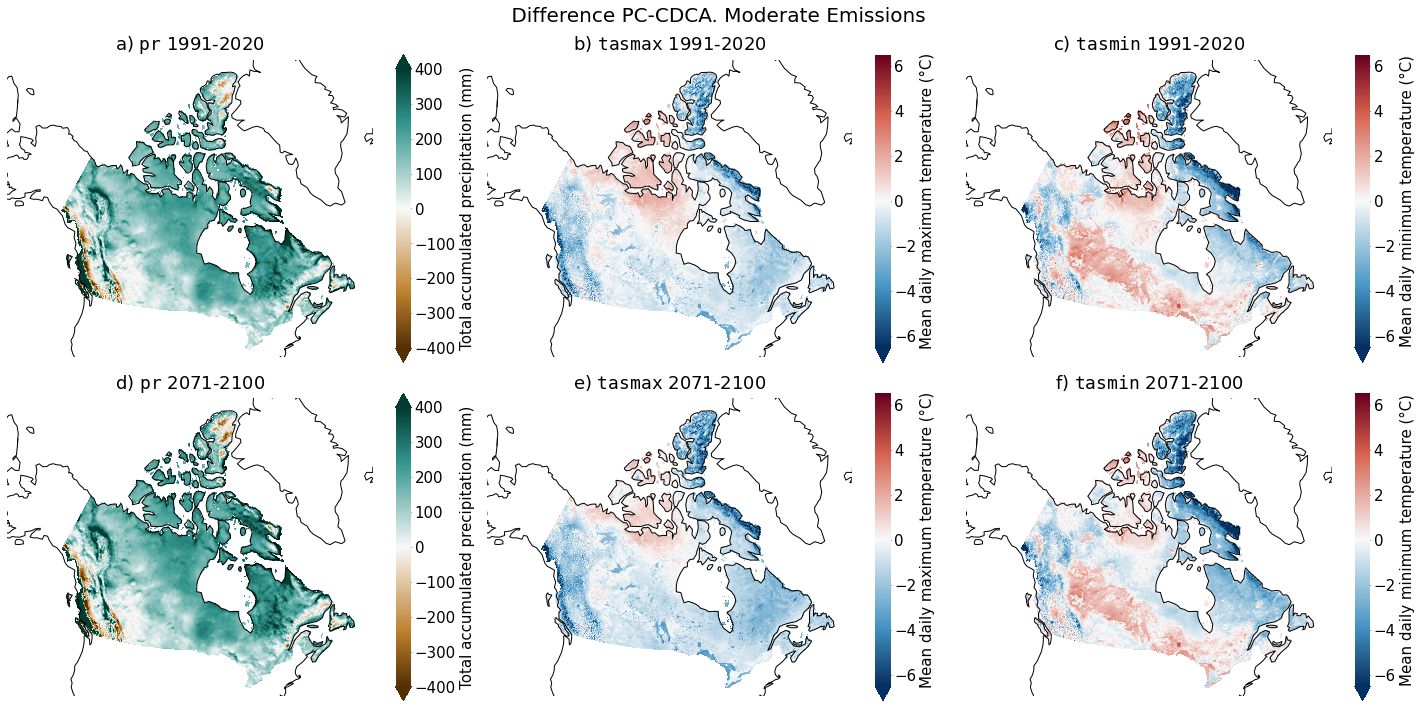

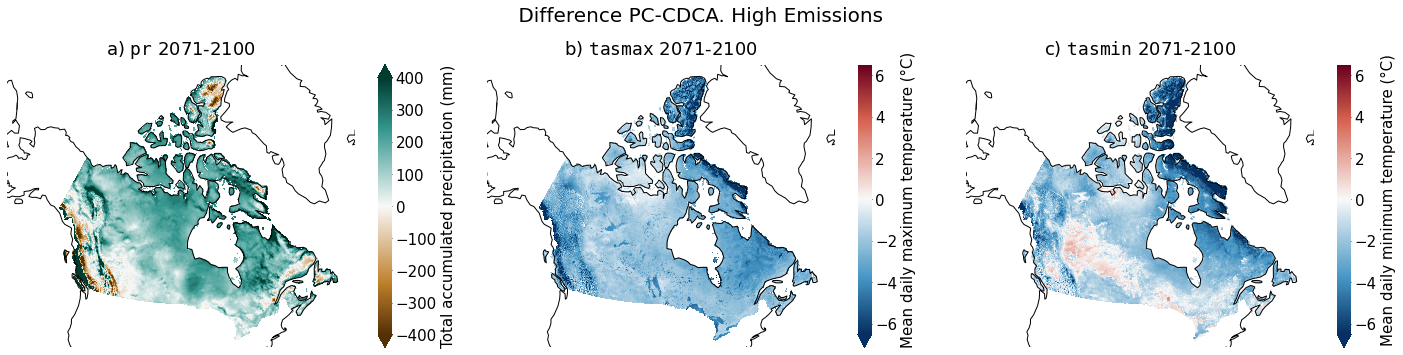

In [6]:
#*diff CD and PC climatology

for exp_pcic, exp_espo, exp_title in zip(['ssp245','ssp585'],['ssp245','ssp370'],
                                         ['Moderate Emissions','High Emissions']):
    print(exp_title)
    
    fig,axs = plt.subplots(2 if exp_title == 'Moderate Emissions' else 1,
                           3,
                           figsize=(20,10) if exp_title == 'Moderate Emissions' else (20,5),
                           subplot_kw={"projection": map_proj})

    horizons=['1991-2020','2071-2100'] if exp_title == 'Moderate Emissions' else ['2071-2100']
    for j,horizon in enumerate(horizons):
        year = horizon.split('-')[0]
        for i,var in enumerate(['prcptot', 'tx_mean', 'tn_mean']):

            for xrfreq in ['AS-JAN']:

                variables= [f"{var}_{p}" for p in ['p10','p50','p90']]



                #pcic ensemble
                ens_pcic = pcat.search(xrfreq=xrfreq,
                                       variable=variables,
                                       bias_adjust_project='climatedata',
                                       processing_level='ensemble-30ymean',
                                       domain='CAN-PCIC',
                                       experiment=exp_pcic).to_dask(**tdd).sel(time=year)

                #espo ensemble
                ens_espo = pcat.search(xrfreq=xrfreq,
                                       variable=variables,
                                       bias_adjust_project='ESPO-G6-R2',
                                       processing_level='ensemble-climatology',
                                       domain='CAN-PCIC',
                                       experiment=exp_espo).to_dask(**tdd).sel(time=year)


                #selection
                cur_pcic = ens_pcic[f'{var}_p50']
                cur_espo = ens_espo[f'{var}_p50']



                with xr.set_options(keep_attrs=True):
                    if var =='prcptot':
                        diff = cur_espo - cur_pcic
                        plot_kw={'vmin':-400, 'vmax':400}
                    else:
                        cur_espo= xc.units.convert_units_to(cur_espo, 'degC')
                        cur_pcic= xc.units.convert_units_to(cur_pcic, 'degC')
                        diff = (cur_espo - cur_pcic)
                        plot_kw={'vmin':-6.5, 'vmax':6.5}

                print(var, diff.max().values, diff.min().values, diff.mean().values, diff.std().values)
                
                ax=axs[j,i] if exp_title == 'Moderate Emissions' else axs[i]
                
                sp.gridmap(diff.squeeze(), ax=ax, divergent=0, features=['coastline'], plot_kw=plot_kw)

                ax.set_title(f'{string.ascii_lowercase[i+(3*j)]}) {var2name[var]} {horizon}', fontsize=18)
                ax.collections[-1].colorbar.outline.set_visible(False)
                ax.collections[-1].colorbar.set_label(
                    f"{diff.attrs['long_name']} ({diff.attrs['units']})".replace('30-year mean of ',''), fontsize=15)
                ax.collections[-1].colorbar.ax.tick_params(labelsize=15)


            fig.tight_layout()
            fig.suptitle(f' Difference PC-CDCA. {exp_title}', fontsize=20)
    name_fig= 'mod' if exp_pcic=='ssp245' else 'high'
    plt.savefig(f"{CONFIG['paths']['figures']}diff_{name_fig}_clim.pdf", bbox_inches='tight')

Moderate Emissions
prcptot 2434.2075 -339.76157 30.821428 56.992264
tx_mean 7.536022 -19.556465 -0.70183164 2.0389647
tn_mean 10.405716 -15.516621 -0.33738947 2.300836


ERROR:fiona._env:PROJ: proj_identify: Cannot find proj.db


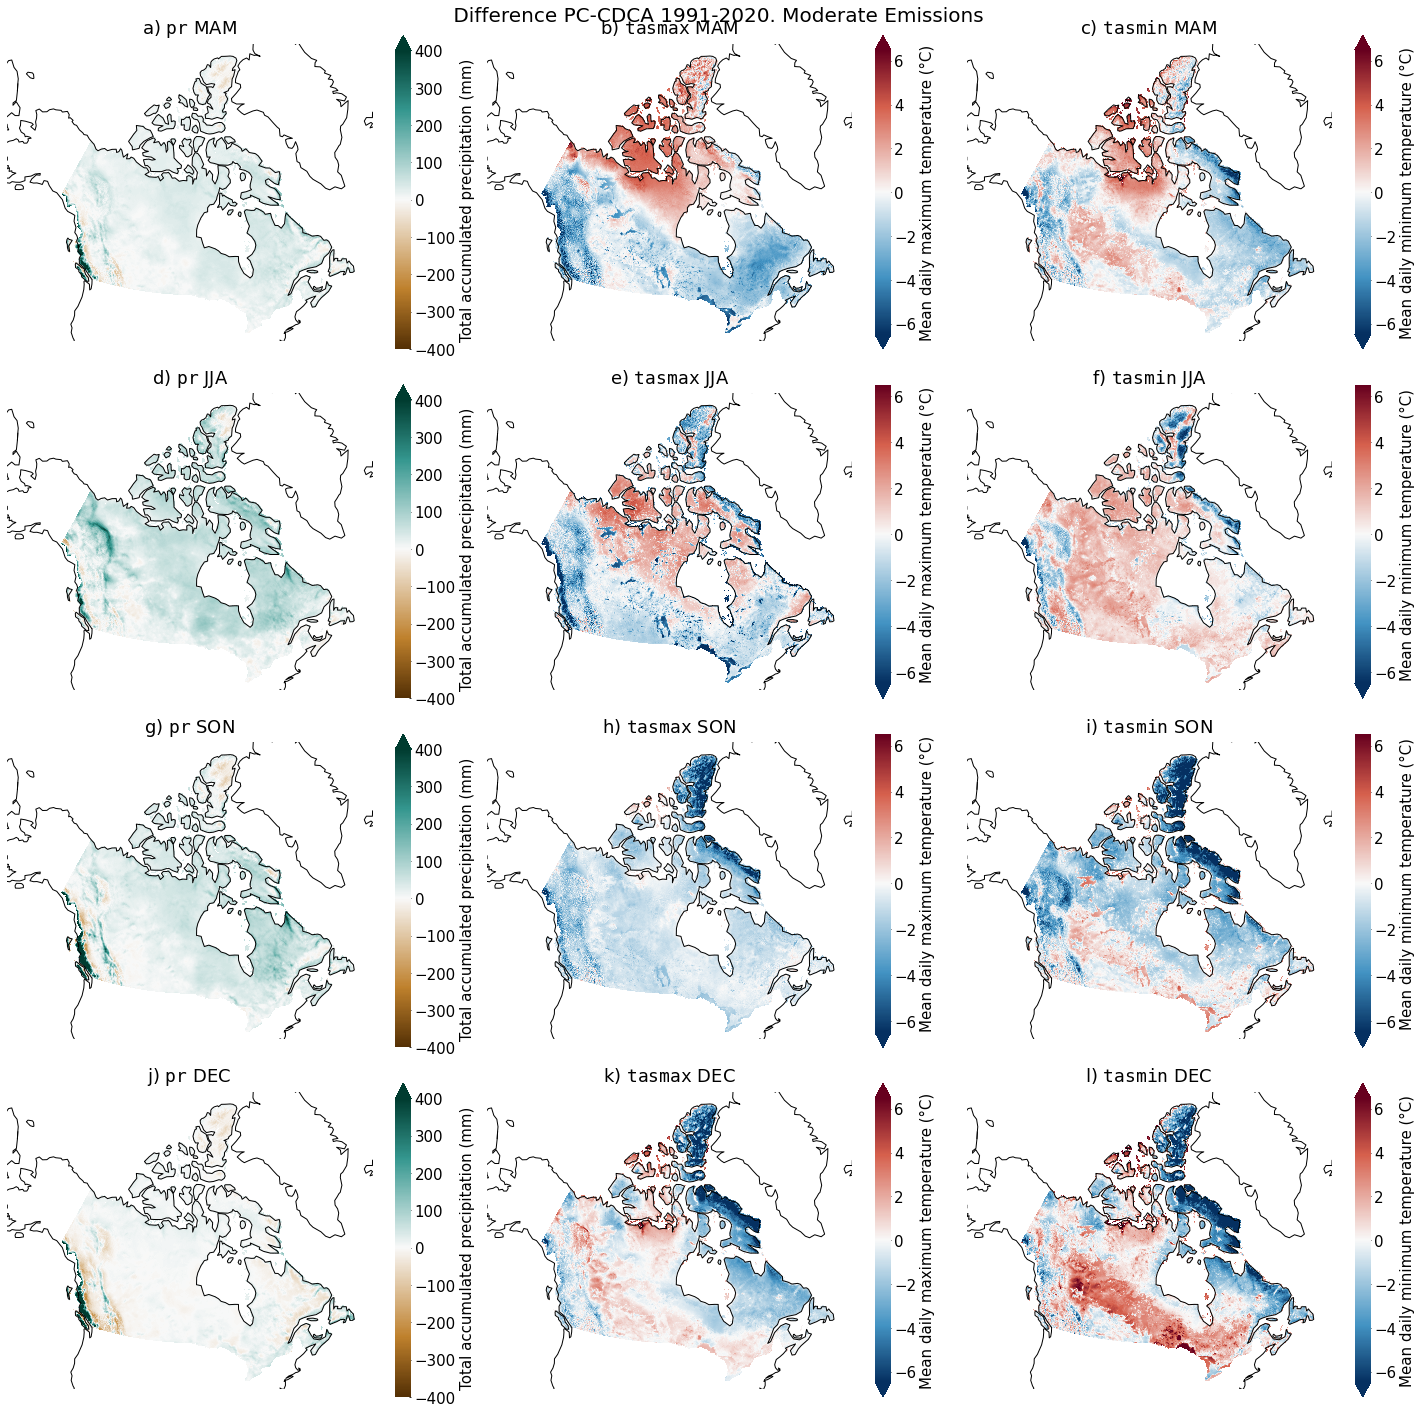

In [5]:
#*diff CD and PC climatology

for exp_pcic, exp_espo, exp_title in zip(['ssp245'],['ssp245'],
                                         ['Moderate Emissions']):
    print(exp_title)
    fig,axs = plt.subplots(4,3, figsize=(20,20),subplot_kw={"projection": map_proj})


    for k,horizon in enumerate(['1991-2020']):
        year = horizon.split('-')[0]
        for i,var in enumerate(['prcptot', 'tx_mean', 'tn_mean']):

            for xrfreq in ['QS-DEC']:

                variables= [f"{var}_{p}" for p in ['p10','p50','p90']]



                #pcic ensemble
                ens_pcic = pcat.search(xrfreq=xrfreq,
                                       variable=variables,
                                       bias_adjust_project='climatedata',
                                       processing_level='ensemble-30ymean',
                                       domain='CAN-PCIC',
                                       experiment=exp_pcic).to_dask(**tdd).sel(time=year)

                #espo ensemble
                ens_espo = pcat.search(xrfreq=xrfreq,
                                       variable=variables,
                                       bias_adjust_project='ESPO-G6-R2',
                                       processing_level='ensemble-climatology',
                                       domain='CAN-PCIC',
                                       experiment=exp_espo).to_dask(**tdd).sel(time=year)


                #selection
                cur_pcic = ens_pcic[f'{var}_p50']
                cur_espo = ens_espo[f'{var}_p50']



                with xr.set_options(keep_attrs=True):
                    if var =='prcptot':
                        diff = cur_espo - cur_pcic
                        plot_kw={'vmin':-400, 'vmax':400}
                    else:
                        cur_espo= xc.units.convert_units_to(cur_espo, 'degC')
                        cur_pcic= xc.units.convert_units_to(cur_pcic, 'degC')
                        diff = (cur_espo - cur_pcic)
                        plot_kw={'vmin':-6.5, 'vmax':6.5}

                print(var, diff.max().values, diff.min().values, diff.mean().values, diff.std().values)
                for j,(time,season) in enumerate(zip(['1991-03-01', '1991-06-01','1991-09-01', '1991-12-01'],
                                            ['MAM','JJA','SON','DEC'])):
                    sp.gridmap(diff.sel(time=time).squeeze(), ax=axs[j,i], divergent=0, features=['coastline'], plot_kw=plot_kw)

                    axs[j,i].set_title(f'{string.ascii_lowercase[i+(3*j)]}) {var2name[var]} {season} ', fontsize=18)
                    axs[j,i].collections[-1].colorbar.outline.set_visible(False)
                    axs[j,i].collections[-1].colorbar.set_label(
                        f"{diff.attrs['long_name']} ({diff.attrs['units']})".replace('30-year mean of ',''), fontsize=15)
                    axs[j,i].collections[-1].colorbar.ax.tick_params(labelsize=15)


            fig.tight_layout()
            fig.suptitle(f' Difference PC-CDCA {horizon}. {exp_title}', fontsize=20)


# projected change

/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.


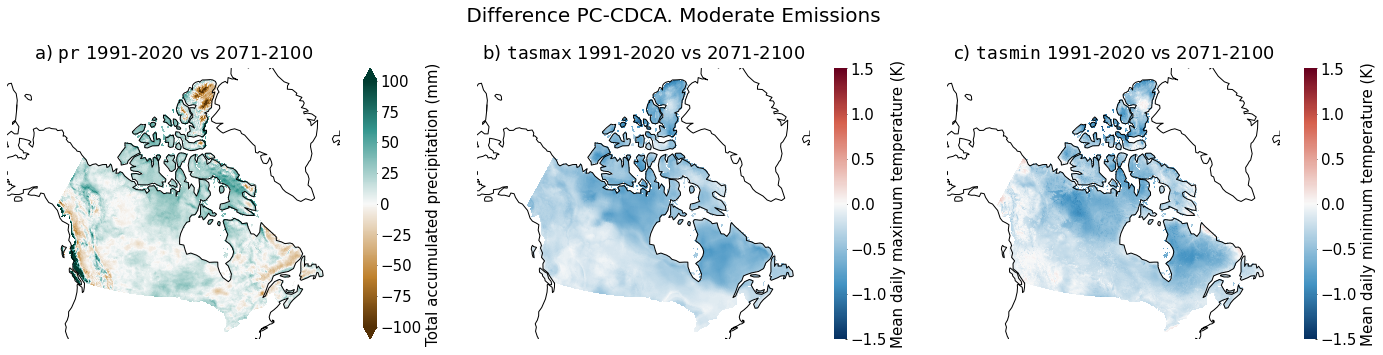

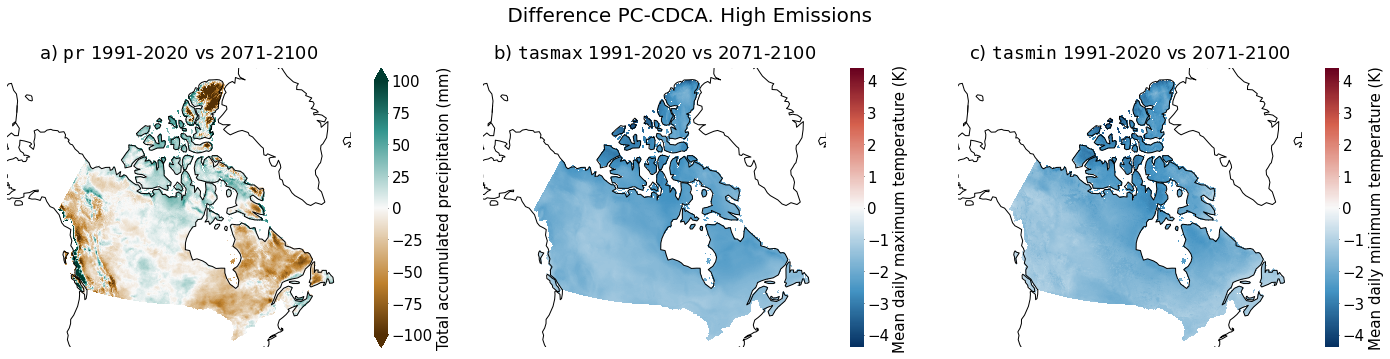

In [5]:
#*diff CD and PC delta
horizon= '2071-2100'
year = horizon.split('-')[0]
for exp_pcic, exp_espo, exp_title in zip(['ssp245','ssp585'],['ssp245','ssp370'],
                                         ['Moderate Emissions','High Emissions']):
    fig,axs = plt.subplots(1,3, figsize=(20,5),subplot_kw={"projection": map_proj})
    for i,var in enumerate(['prcptot', 'tx_mean', 'tn_mean']):
        for xrfreq in ['AS-JAN']:

            variables= [f"{var}_delta_1991_2020_{p}" for p in ['p10','p50','p90']]

            level =  'ensemble-30ymean'
            #pcic ensemble
            ens_pcic = pcat.search(xrfreq=xrfreq,
                                   variable=variables,
                                   bias_adjust_project='climatedata',
                                   processing_level=level,
                                   domain='CAN-PCIC',
                                   experiment=exp_pcic).to_dask(**tdd).sel(time=year)

            #espo ensemble
            level =  'ensemble-abs-delta-1991-2020'
            ens_espo = pcat.search(xrfreq=xrfreq,
                                   variable=variables,
                                   bias_adjust_project='ESPO-G6-R2',
                                   processing_level=level,
                                   domain='CAN-PCIC',
                                   experiment=exp_espo).to_dask(**tdd).sel(time=year)


            #selection
            cur_pcic = ens_pcic[f'{var}_delta_1991_2020_p50']
            cur_espo = ens_espo[f'{var}_delta_1991_2020_p50']
            
            #difference
            with xr.set_options(keep_attrs=True):
                diff = (cur_espo - cur_pcic)
                
            if var =='prcptot':
                plot_kw= {'vmax':100,'vmin':-100}
            elif exp_espo=='ssp245':
                plot_kw= {'vmax':1.5,'vmin':-1.5}
            else:
                plot_kw= {'vmax':4.4,'vmin':-4.4}
            
            #plot
            sp.gridmap(diff.squeeze(), ax=axs[i], divergent=0, features=['coastline'],plot_kw=plot_kw)
            fig.suptitle(f' Difference PC-CDCA. {exp_title}', fontsize=20)
            axs[i].set_title(f'{string.ascii_lowercase[i]}) {var2name[var]} 1991-2020 vs {horizon}', fontsize=18)
            axs[i].collections[-1].colorbar.outline.set_visible(False)
            axs[i].collections[-1].colorbar.set_label(
                f"{diff.attrs['long_name'].split(':')[0]} ({diff.attrs['units']})".replace('30-year mean of ',''),
                fontsize=15)
            axs[i].collections[-1].colorbar.ax.tick_params(labelsize=15)
            fig.tight_layout()
    name_fig= 'mod' if exp_pcic=='ssp245' else 'high'
    plt.savefig(f"{CONFIG['paths']['figures']}diff_{name_fig}_delta.pdf", bbox_inches='tight')


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: Us

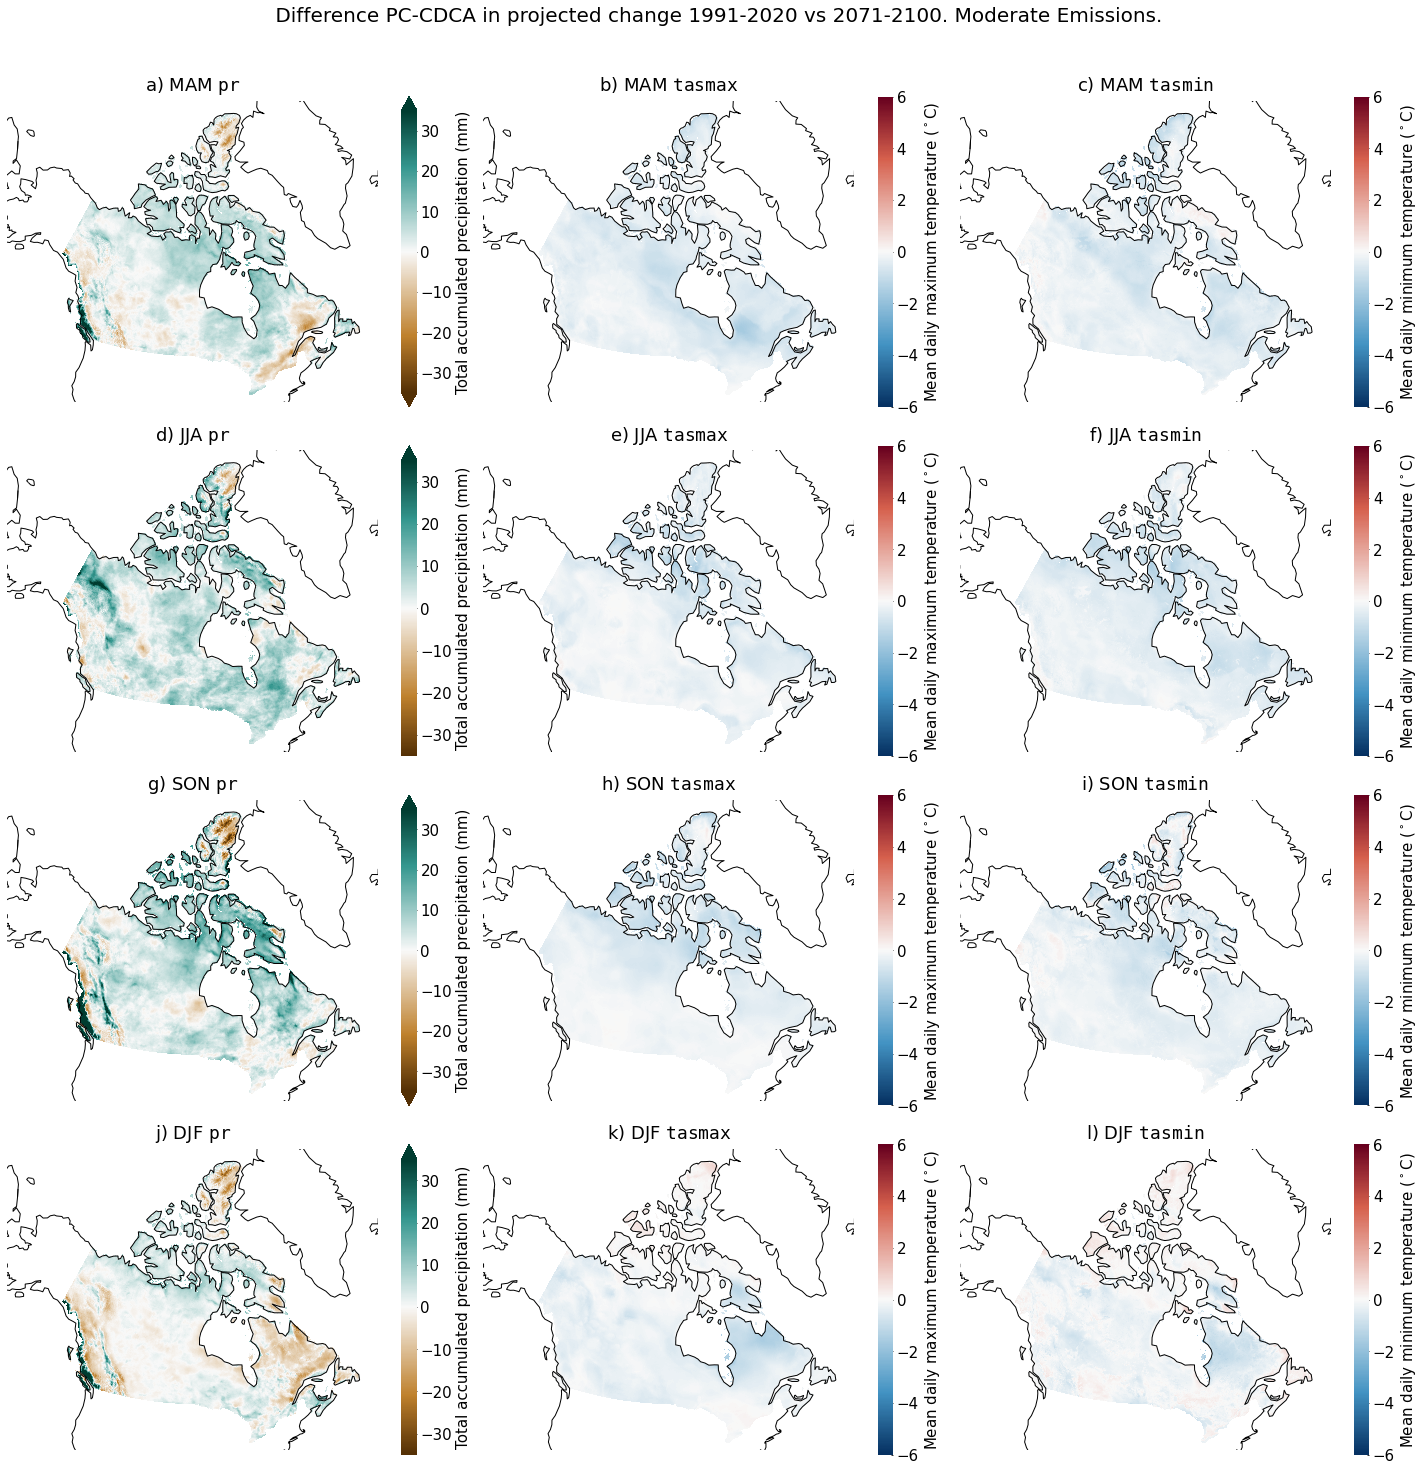

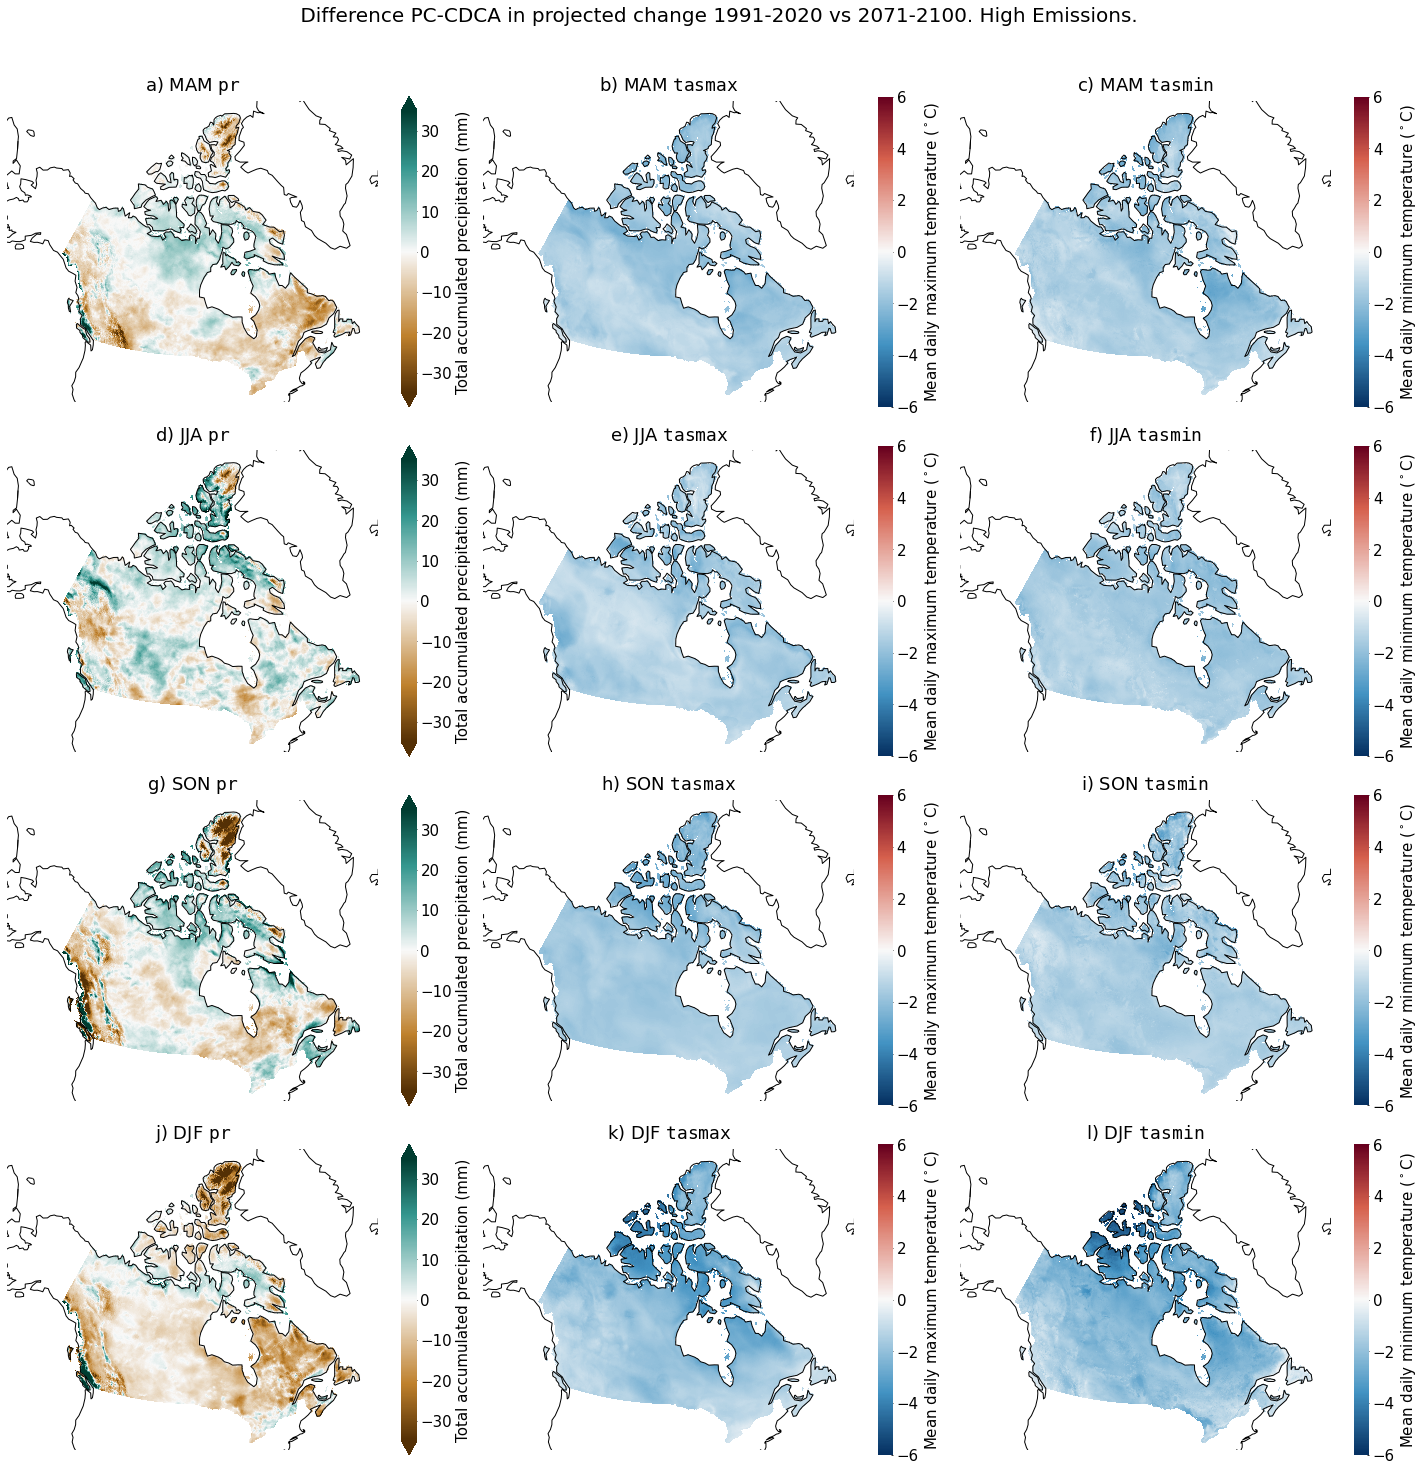

In [8]:
#*diff CD and PC delta seasonal
horizon= '2071-2100'
year = horizon.split('-')[0]
for exp_pcic, exp_espo, exp_title in zip(['ssp245','ssp585'],['ssp245','ssp370'],
                                         ['Moderate Emissions','High Emissions']):
    fig,axs = plt.subplots(4,3, figsize=(20,20),subplot_kw={"projection": map_proj})
    for j,var in enumerate(['prcptot', 'tx_mean', 'tn_mean']):
        for xrfreq in ['QS-DEC']:

            variables= [f"{var}_delta_1991_2020_{p}" for p in ['p10','p50','p90']]

            level =  'ensemble-30ymean'

            #pcic ensemble
            ens_pcic = pcat.search(xrfreq=xrfreq,
                                   variable=variables,
                                   bias_adjust_project='climatedata',
                                   processing_level=level,
                                   domain='CAN-PCIC',
                                   experiment=exp_pcic).to_dask(**tdd)
            ens_pcic = ens_pcic.sel(time=year)

            #espo ensemble
            level =   'ensemble-abs-delta-1991-2020'
            ens_espo = pcat.search(xrfreq=xrfreq,
                                   variable=variables,
                                   bias_adjust_project='ESPO-G6-R2',
                                   processing_level=level,
                                   domain='CAN-PCIC',
                                   experiment=exp_espo).to_dask(**tdd)
            ens_espo = ens_espo.sel(time=year)


            #selection
            cur_pcic = ens_pcic[f'{var}_delta_1991_2020_p50']
            cur_espo = ens_espo[f'{var}_delta_1991_2020_p50']

            with xr.set_options(keep_attrs=True):
                diff = (cur_espo - cur_pcic)

                if var =='prcptot':
                    plot_kw={'vmin':-35, 'vmax':35}
                else:
                    plot_kw={'vmin':-6, 'vmax':6}
                    #plot_kw={}
                    diff.attrs['units']= "$^\circ$C"

            for i,(time,season) in enumerate(zip(['2071-03-01', '2071-06-01','2071-09-01', '2071-12-01'],
                                                ['MAM','JJA','SON','DJF'])):
                sp.gridmap(diff.sel(time=time).squeeze(), ax=axs[i,j], divergent=0, features=['coastline'], plot_kw=plot_kw)
                axs[i,j].set_title(f'{string.ascii_lowercase[j+(3*i)]}) {season} {var2name[var]}', fontsize=18)
                axs[i,j].collections[-1].colorbar.outline.set_visible(False)
                axs[i,j].collections[-1].colorbar.set_label(
                    f"{diff.attrs['long_name'].split(':')[0]} ({diff.attrs['units']})".replace('30-year mean of ',''),
                    fontsize=15)
                axs[i,j].collections[-1].colorbar.ax.tick_params(labelsize=15)

            fig.suptitle(f' Difference PC-CDCA in projected change 1991-2020 vs {horizon}. {exp_title}.', fontsize=20, y=1.02)
            fig.tight_layout()


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: Us

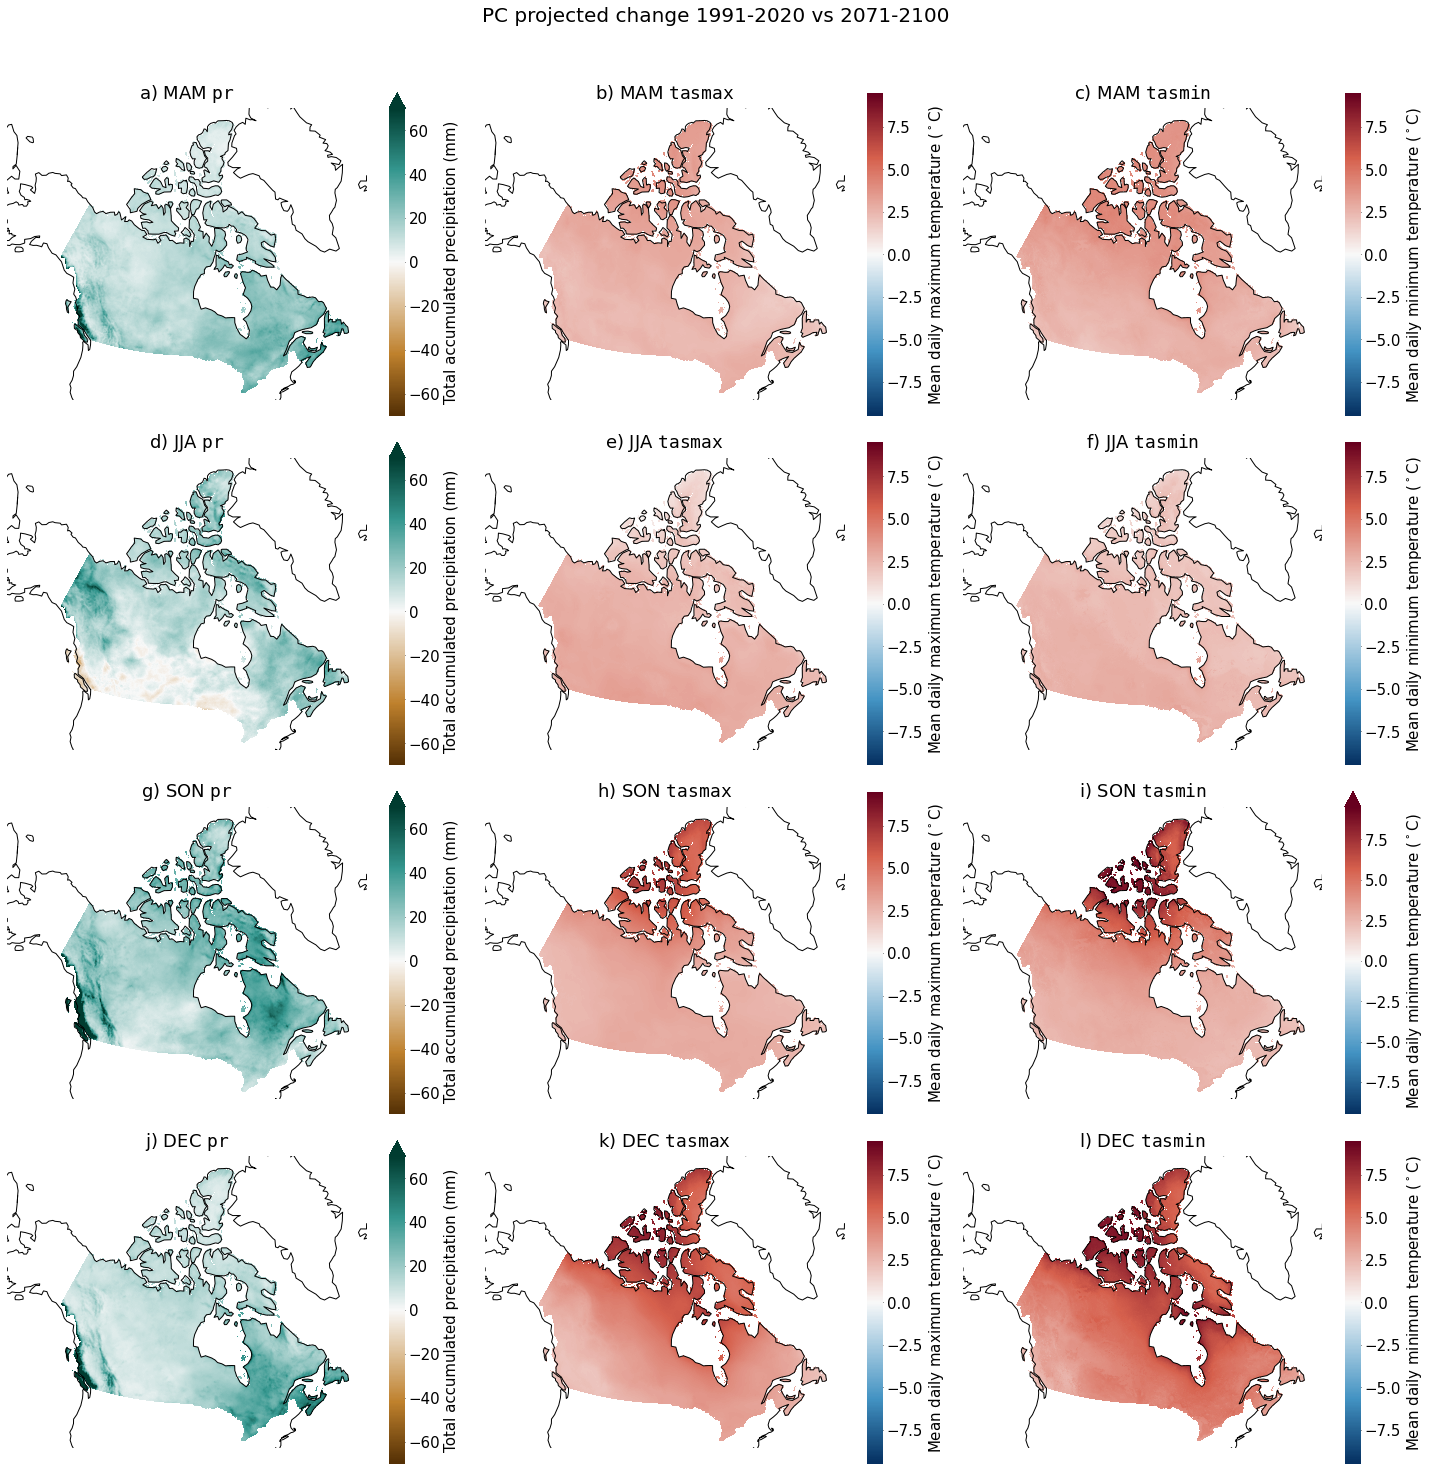

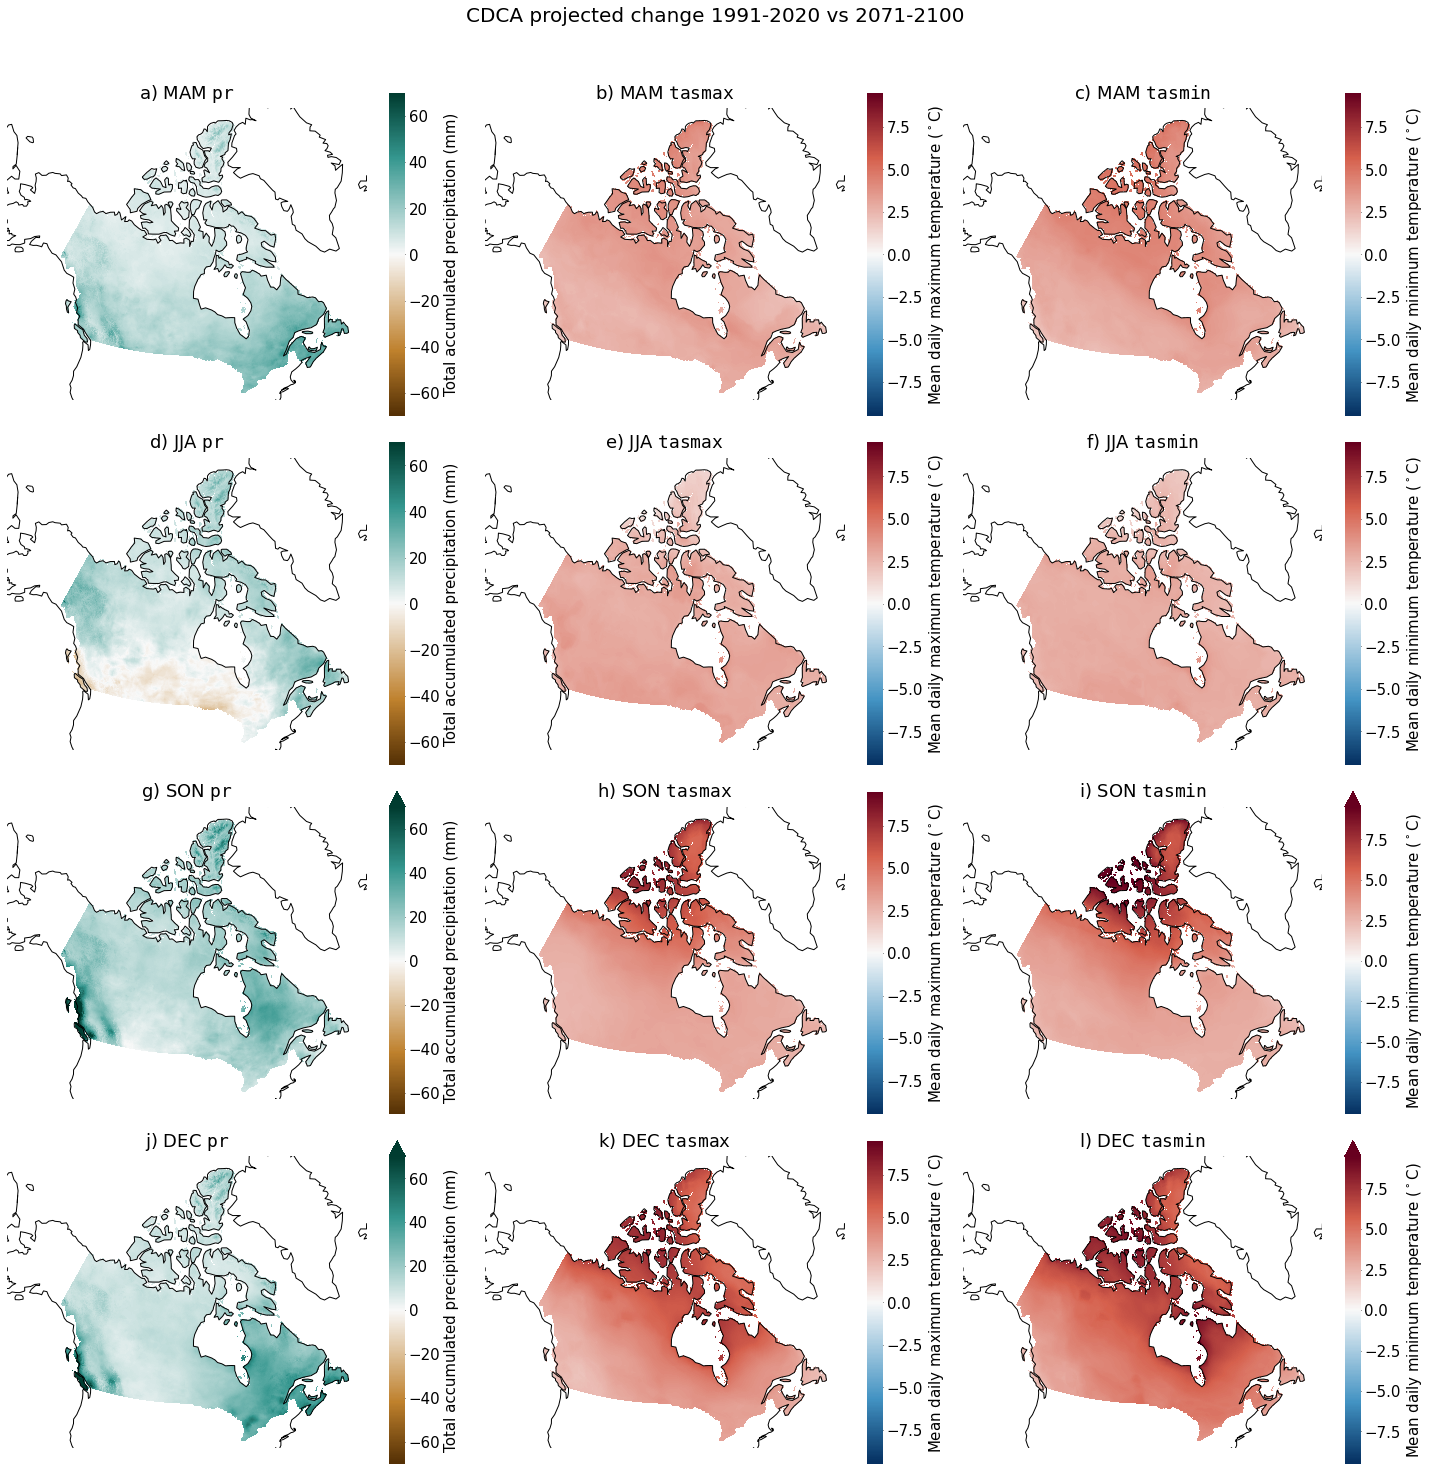

In [4]:
#*individual CD and PC delta seasonal
horizon= '2071-2100'
year = horizon.split('-')[0]
map_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)
fig1,axs1 = plt.subplots(4,3, figsize=(20,20),subplot_kw={"projection": map_proj})
fig2,axs2 = plt.subplots(4,3, figsize=(20,20),subplot_kw={"projection": map_proj})

for j,var in enumerate(['prcptot', 'tx_mean', 'tn_mean']):
    for xrfreq in ['QS-DEC']:
        
        variables= [f"{var}_delta_1991_2020_{p}" for p in ['p10','p50','p90']]
        
        level =  'ensemble-30ymean'
        
        #pcic ensemble
        ens_pcic = pcat.search(xrfreq=xrfreq,
                               variable=variables,
                               bias_adjust_project='climatedata',
                               processing_level=level,
                               domain='CAN-PCIC',
                               experiment='ssp245').to_dask(**tdd)
        ens_pcic = ens_pcic.sel(time=year)
        
        #espo ensemble
        level =  'ensemble-abs-delta-1991-2020'
        ens_espo = pcat.search(xrfreq=xrfreq,
                               variable=variables,
                               bias_adjust_project='ESPO-G6-R2',
                               processing_level=level,
                               domain='CAN-PCIC',
                               experiment='ssp245').to_dask(**tdd)
        ens_espo = ens_espo.sel(time=year)
        
            
        #selection
        cur_pcic = ens_pcic[f'{var}_delta_1991_2020_p50']
        cur_espo = ens_espo[f'{var}_delta_1991_2020_p50']
        
        cur_pcic.attrs['history']=cur_espo.attrs['history']

            
        if var =='prcptot':
            plot_kw={'vmin':-70, 'vmax':70}
        else:
            plot_kw={'vmin':-9.5, 'vmax':9.5}
            cur_espo.attrs['units']= "$^\circ$C"
            cur_pcic.attrs['units']= "$^\circ$C"

        for i,(time,season) in enumerate(zip(['2071-03-01', '2071-06-01','2071-09-01', '2071-12-01'],
                                            ['MAM','JJA','SON','DEC'])):
            sp.gridmap(cur_espo.sel(time=time).squeeze(), ax=axs1[i,j], divergent=0, features=['coastline'], plot_kw=plot_kw)
            axs1[i,j].set_title(f'{string.ascii_lowercase[j+(3*i)]}) {season} {var2name[var]}', fontsize=18)
            axs1[i,j].collections[-1].colorbar.outline.set_visible(False)
            axs1[i,j].collections[-1].colorbar.set_label(
                f"{cur_espo.attrs['long_name'].split(':')[0]} ({cur_espo.attrs['units']})".replace('30-year mean of ',''),
                fontsize=15)
            axs1[i,j].collections[-1].colorbar.ax.tick_params(labelsize=15)
            fig1.suptitle(f'PC projected change 1991-2020 vs {horizon}', fontsize=20, y=1.02)

            
            sp.gridmap(cur_pcic.sel(time=time).squeeze(), ax=axs2[i,j], divergent=0, features=['coastline'], plot_kw=plot_kw)
            axs2[i,j].set_title(f'{string.ascii_lowercase[j+(3*i)]}) {season} {var2name[var]}', fontsize=18)
            axs2[i,j].collections[-1].colorbar.outline.set_visible(False)
            axs2[i,j].collections[-1].colorbar.set_label(
                f"{cur_espo.attrs['long_name'].split(':')[0]} ({cur_espo.attrs['units']})".replace('30-year mean of ',''),
                fontsize=15)
            axs2[i,j].collections[-1].colorbar.ax.tick_params(labelsize=15)
            fig2.suptitle(f'CDCA projected change 1991-2020 vs {horizon}', fontsize=20, y=1.02)

        
fig1.tight_layout()
fig2.tight_layout()


#  Compare References

In [3]:
pcat_ref = xs.ProjectCatalog(CONFIG['paths']['ref_cat'])
pcat_ref.df.source.unique()

['RDRS', 'NRCAN']
Categories (2, object): ['NRCAN', 'RDRS']

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:45530
INFO:distributed.scheduler:  dashboard at:            127.0.0.1:6786
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40240'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44983'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:33166', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:33166
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:41722
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:34368', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:34368
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:41716
INFO:distributed.scheduler:Receive client connection: Client-d91c901d-166b-11ee-91c8-0cc47a3a8380
INF

Removing /exec/jlavoie/tmp/diff.zarr/tx_mean to overwrite.
Removing /exec/jlavoie/tmp/diff.zarr/tn_mean to overwrite.
Removing /exec/jlavoie/tmp/diff.zarr/prcptot to overwrite.


INFO:distributed.core:Event loop was unresponsive in Scheduler for 3.14s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 10.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 10.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause t

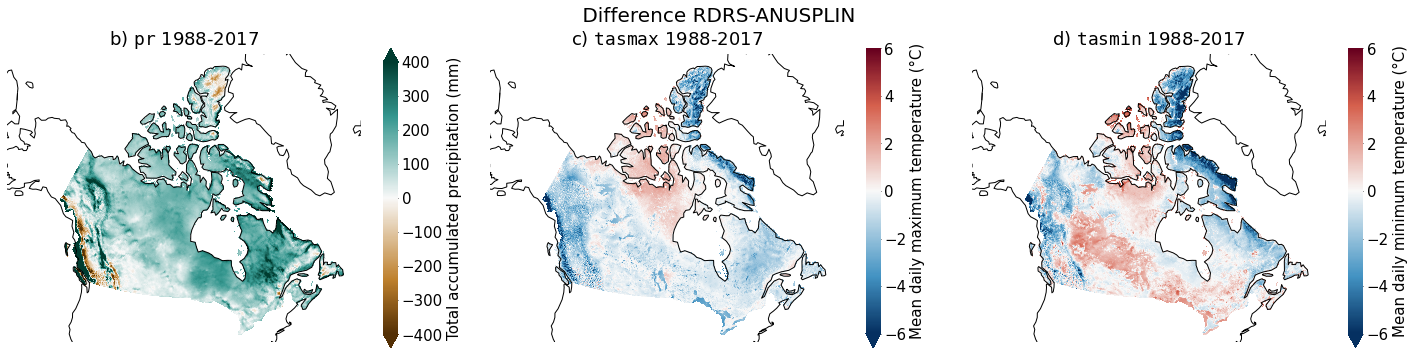

In [38]:
with Client(n_workers=2, threads_per_worker=2,dashboard_address= 6786, memory_limit="30GB",local_directory= CONFIG['paths']['local_directory'] ):

    fig,axs = plt.subplots(1,3, figsize=(20,5),subplot_kw={"projection": map_proj})
    
    period=["1988","2017"]
    horizon='-'.join(period)
    sources={}
    for source in ['NRCAN','RDRS']:
        ds = pcat_ref.search(source=source,variable=['tasmax', 'tasmin', 'pr'],
                             xrfreq='D',).to_dataset(**tdd).sel(time=slice(*map(str, period)))
        _, ds_ind = xs.compute_indicators(
            ds=ds,
            indicators="basic_var.yml",
        ).popitem()

        ds_mean = xs.climatological_mean(
            ds=ds_ind, window=30
        )
        
        #regrid on NRCAN
        if source=='RDRS':
            mask_args = {
                    "variable": 'tx_mean',
                    "where_operator": "<",
                    "where_threshold": 100000000,
                    "mask_nans": True
                }
            sources['NRCAN']["mask"] = xs.create_mask(sources['NRCAN'], mask_args=mask_args)
            ds_mean["mask"] = xs.create_mask(ds_mean, mask_args=mask_args)

            
            ds_mean = xs.regrid_dataset(
                            ds=ds_mean.chunk({'rlat':-1, 'rlon':-1}),
                            weights_location=CONFIG['paths']['weights_location'],
                            ds_grid=sources['NRCAN'],
                            regridder_kwargs={"extrap_method": "inverse_dist"},
                            )
        ds_mean['tx_mean']=xc.units.convert_units_to(ds_mean['tx_mean'], 'degC')
        ds_mean['tn_mean']=xc.units.convert_units_to(ds_mean['tn_mean'], 'degC')
        sources[source]=ds_mean
        

    diff = sources['RDRS']-sources['NRCAN']
    xs.save_to_zarr(diff, '/exec/jlavoie/tmp/diff.zarr', mode='o')

    for i,var in enumerate(['prcptot', 'tx_mean', 'tn_mean']): 
        diff[var].attrs = sources['RDRS'][var].attrs
        
        if var =='prcptot':
            plot_kw={'vmin':-400, 'vmax':400}
        else:
            plot_kw={'vmin':-6, 'vmax':6}
        
        sp.gridmap(diff[var].squeeze(), ax=axs[i], divergent=0, features=['coastline'], plot_kw=plot_kw)

        axs[i].set_title(f'{string.ascii_lowercase[i+1]}) {var2name[var]} {horizon}', fontsize=18)
        axs[i].collections[-1].colorbar.outline.set_visible(False)
        axs[i].collections[-1].colorbar.set_label(
            f"{diff[var].attrs['long_name']} ({diff[var].attrs['units']})".replace('30-year mean of ',''),
            fontsize=15)
        axs[i].collections[-1].colorbar.ax.tick_params(labelsize=15)

    fig.suptitle(f' Difference RDRS-ANUSPLIN', fontsize=20)
    fig.tight_layout()
